<a href="https://colab.research.google.com/github/Lary2801/ProjetoRegressaoLinear/blob/main/Regress%C3%A3o_Linear_Influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Carregar os dados
df = pd.read_csv('top_insta_influencers_data.csv')

# Exibir as primeiras linhas para entender a estrutura
print(df.head())


   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%            665.3k       12.5b  United States  


Valores nulos por coluna:
 rank                  0
channel_info          0
influence_score       0
posts                 0
followers             0
avg_likes             0
60_day_eng_rate       0
new_post_avg_like     0
total_likes           0
country              62
dtype: int64


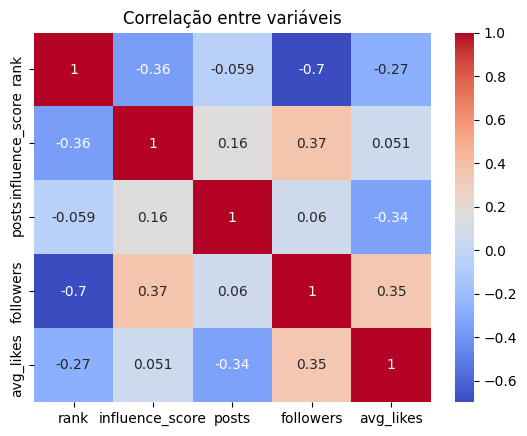

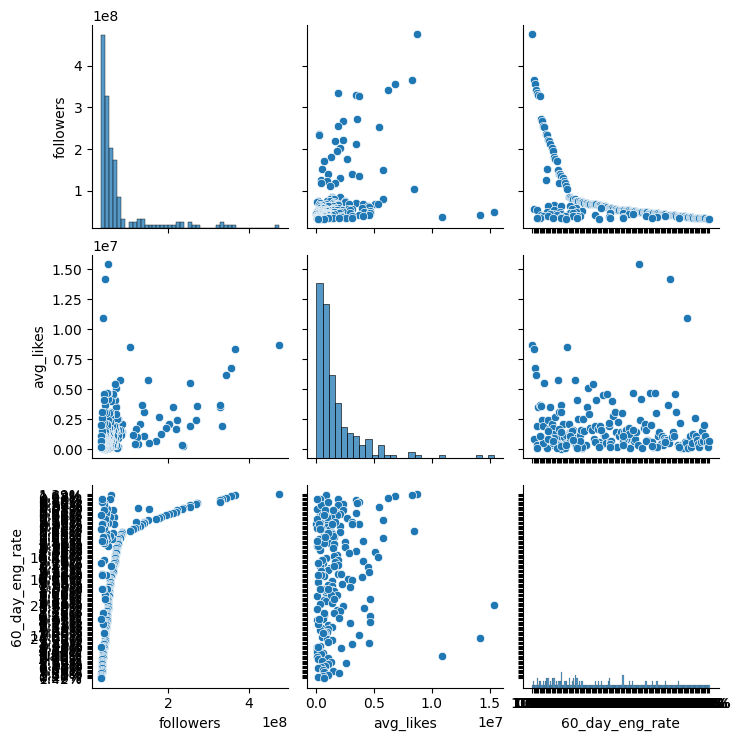

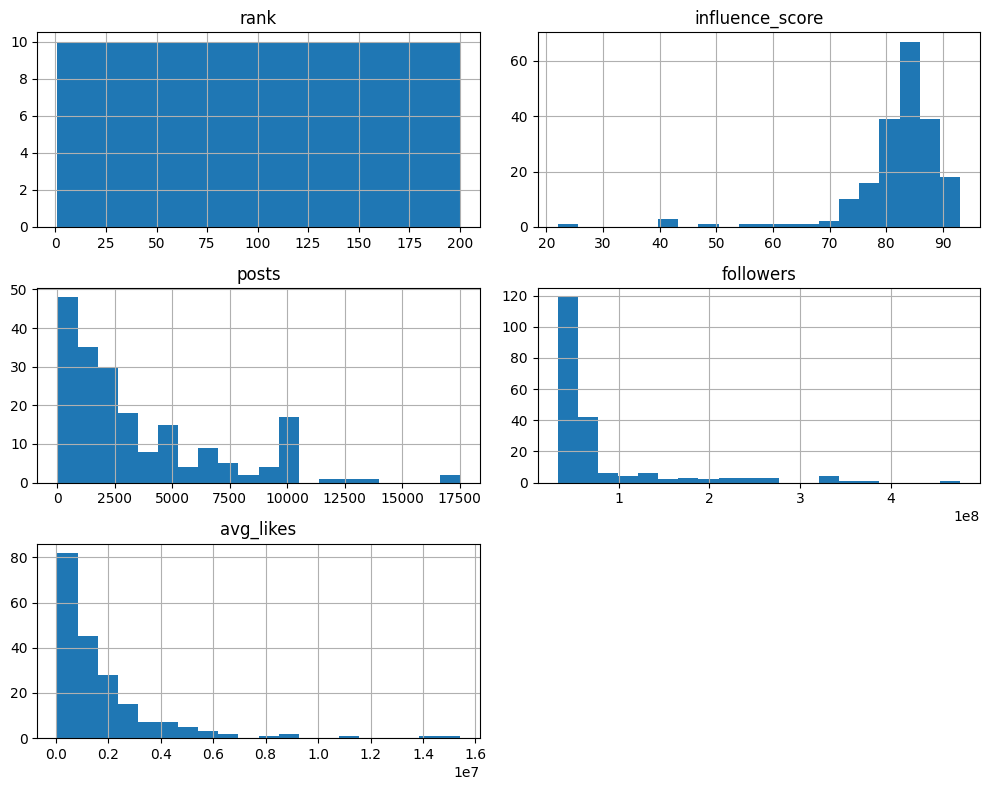

In [26]:
# Verificar valores nulos
print("Valores nulos por coluna:\n", df.isnull().sum())

# Converter colunas relevantes para valores numéricos
def converter_para_numero(valor):
    if isinstance(valor, str):
        if 'k' in valor:
            return float(valor.replace('k', '').replace(',', '')) * 1e3
        elif 'm' in valor:
            return float(valor.replace('m', '').replace(',', '')) * 1e6
    return valor

colunas_para_converter = ['followers', 'posts', 'avg_likes', 'new_post_avg_like']
for coluna in colunas_para_converter:
    if coluna in df.columns:
        df[coluna] = df[coluna].apply(converter_para_numero)

# Remover valores nulos em '60_day_eng_rate'
df = df.dropna(subset=['60_day_eng_rate'])

# Verificar correlações entre variáveis numéricas
df_numerico = df.select_dtypes(include=np.number)
sns.heatmap(df_numerico.corr(), annot=True, cmap='coolwarm')
plt.title("Correlação entre variáveis")
plt.show()

# Gráficos adicionais para análise exploratória
sns.pairplot(df, vars=['followers', 'avg_likes', '60_day_eng_rate'])
plt.show()

# Histograma das variáveis numéricas
df_numerico.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()


In [27]:
# Definir variáveis independentes e dependente
X = df[['followers', 'posts', 'avg_likes', 'new_post_avg_like']]

# Remover o símbolo de porcentagem em y e converter para float
y = df['60_day_eng_rate'].replace('%', '', regex=True).astype(float) / 100  # Dividir por 100 para obter a porcentagem real

# Verificar se há valores NaN em y e remover essas linhas
y = y.dropna()

# Reajustar X para as novas dimensões de y (remover linhas com NaN em y)
X = X.loc[y.index]

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Seleção de variáveis mais relevantes
selector = SelectKBest(score_func=f_regression, k='all')
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Exibir os scores das variáveis selecionadas
print("Scores das variáveis selecionadas:", selector.scores_)



Scores das variáveis selecionadas: [  1.338378    19.44156474 219.33183213 446.57085005]


In [28]:
# Criar o modelo de Regressão Linear
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Inicializar o modelo
modelo = LinearRegression()

# Treinamento do modelo com o conjunto de dados de treino
modelo.fit(X_train, y_train)

# Realizar a validação cruzada com 10 partições
cv_scores = cross_val_score(modelo, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Exibir a média e desvio padrão dos erros quadráticos médios
print(f"Validação Cruzada - MSE médio: {-cv_scores.mean()} (± {cv_scores.std()})")

# Fazer previsões nos conjuntos de treino e teste
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

# Métricas de avaliação no conjunto de teste
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Mean Squared Error (MSE) no Teste: {mse}")
print(f"Mean Absolute Error (MAE) no Teste: {mae}")
print(f"R² Score no Teste: {r2}")



Validação Cruzada - MSE médio: 0.00016925965414228773 (± 0.00014626559474004866)
Mean Squared Error (MSE) no Teste: 2.907613487782812e-05
Mean Absolute Error (MAE) no Teste: 0.003531621506341566
R² Score no Teste: 0.9528577922703305


In [29]:
# Regressão Linear com Gradiente Descendente (Stochastic Gradient Descent)
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

# Inicializar o modelo de regressão linear com gradiente descendente
sgd = SGDRegressor(max_iter=1000, tol=1e-3)

# Definir os parâmetros para a busca em grade (valores de taxa de aprendizado e número de iterações)
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],  # Taxa de aprendizado
    'max_iter': [1000, 2000, 3000]    # Número de épocas
}

# Aplicar GridSearchCV para encontrar a melhor combinação de hiperparâmetros
grid_search = GridSearchCV(sgd, param_grid, cv=10, scoring='neg_mean_squared_error')

# Treinar o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print("Melhores Hiperparâmetros:", grid_search.best_params_)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Fazer previsões com o melhor modelo
y_pred_train_sgd = best_model.predict(X_train)
y_pred_test_sgd = best_model.predict(X_test)

# Métricas de avaliação com o modelo de gradiente descendente
mse_sgd = mean_squared_error(y_test, y_pred_test_sgd)
mae_sgd = mean_absolute_error(y_test, y_pred_test_sgd)
r2_sgd = r2_score(y_test, y_pred_test_sgd)

print(f"Mean Squared Error (MSE) - SGD no Teste: {mse_sgd}")
print(f"Mean Absolute Error (MAE) - SGD no Teste: {mae_sgd}")
print(f"R² Score - SGD no Teste: {r2_sgd}")



Melhores Hiperparâmetros: {'alpha': 0.001, 'max_iter': 2000}
Mean Squared Error (MSE) - SGD no Teste: 8.090524748428216e-05
Mean Absolute Error (MAE) - SGD no Teste: 0.006353548291786912
R² Score - SGD no Teste: 0.8688253442436484


In [30]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

# Avaliação
print("Ridge - MSE:", mean_squared_error(y_test, ridge_pred))
print("Lasso - MSE:", mean_squared_error(y_test, lasso_pred))


Ridge - MSE: 2.9140815307422404e-05
Lasso - MSE: 0.0006178603580257902


In [31]:
# Validação cruzada para Linear Regression
scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE (Linear Regression): {-np.mean(scores)}")


Cross-Validation MSE (Linear Regression): 0.00016364893240886032


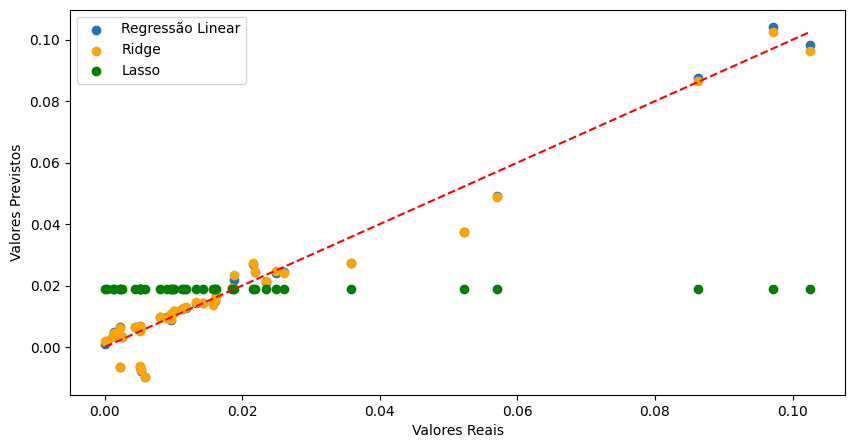

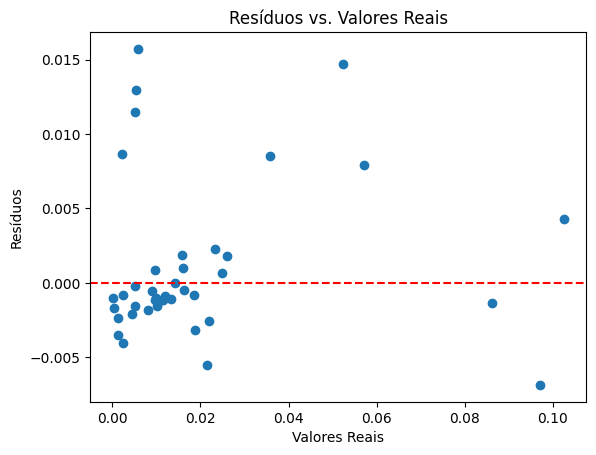

In [32]:
# Comparação entre valores reais e previstos
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_test, label="Regressão Linear")
plt.scatter(y_test, ridge_pred, label="Ridge", color='orange')
plt.scatter(y_test, lasso_pred, label="Lasso", color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.legend()
plt.show()

# Gráfico de resíduos
residuos = y_test - y_pred_test
plt.scatter(y_test, residuos)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs. Valores Reais")
plt.xlabel("Valores Reais")
plt.ylabel("Resíduos")
plt.show()
